In [124]:
# imports and useful variables
import sys
import os
import numpy as np
import pandas as pd
import dask as dd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pylab import rcParams

from datetime import timedelta

# from statsmodels.tsa.forecasting.stl import STLForecast
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle


pd.options.display.float_format = "{:.2f}".format
sns.set_style("whitegrid")
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

# Useful directory variables
src_path = os.getcwd()
root_path = os.path.dirname(src_path)
data_path = root_path + "/datasets"
visualization_path = root_path + "/data_visualization"
consumption_train = pd.read_parquet(
    data_path + "/05_model_input/" + "consumption_train"
)
pressure_train = pd.read_parquet(data_path + "/05_model_input/" + "pressure_train")
print(os.listdir(data_path + "/05_model_input"))
consumption_train.head(2)
# consumption_train.shape
# pressure_train.shape
# consumption_train[consumption_train.duplicated()]
# pressure_train[pressure_train.duplicated()]


consumption_train_pressure = consumption_train[
    ["time", "max_pressure_Bars", "n_working_compressors"]
].copy()
consumption_train_pressure.set_index("time", inplace=True)
consumption_train_pressure = consumption_train_pressure.resample("H").max().copy()
consumption_train_pressure.reset_index(inplace=True)
consumption_train = consumption_train[
    [
        "time",
        "total_average_power_consumption_kW_nodes",
        "total_average_power_consumption_kW_chillers",
        "Temperature_In_Degrees",
        "Temperature_Out_Degrees",
        "Temperature_Ambient_Degrees",
        "Temperature_Evaporator_Degrees",
    ]
].copy()

consumption_train.set_index("time", inplace=True)
consumption_train = consumption_train.resample("H").mean().copy()
consumption_train.reset_index(inplace=True)
consumption_train = pd.merge(consumption_train, consumption_train_pressure, on="time")

# pressure_train_pressure = pressure_train[
#     ["time", "max_pressure_Bars", "n_working_compressors"]
# ].copy()
# pressure_train_pressure.set_index("time", inplace=True)
# pressure_train_pressure = pressure_train_pressure.resample("H").max().copy()
# pressure_train_pressure.reset_index(inplace=True)
# pressure_train = pressure_train[
#     [
#         "time",
#         "total_average_power_consumption_kW_nodes",
#         "total_average_power_consumption_kW_chillers",
#         "Temperature_In_Degrees",
#         "Temperature_Out_Degrees",
#         "Temperature_Ambient_Degrees",
#         "Temperature_Evaporator_Degrees",
#     ]
# ].copy()
# pressure_train.set_index("time", inplace=True)
# pressure_train = pressure_train.resample("H").mean().copy()
# pressure_train.reset_index(inplace=True)
# pressure_train = pd.merge(pressure_train, pressure_train_pressure, on="time")

# pressure_train["year"] = pressure_train.time.dt.year
# pressure_train["month"] = pressure_train.time.dt.month
# pressure_train["week"] = pressure_train.time.dt.week
# pressure_train["day"] = pressure_train.time.dt.day
# pressure_train["hour"] = pressure_train.time.dt.hour

consumption_train["year"] = consumption_train.time.dt.year
consumption_train["month"] = consumption_train.time.dt.month
consumption_train["week"] = consumption_train.time.dt.week
consumption_train["day"] = consumption_train.time.dt.day
consumption_train["hour"] = consumption_train.time.dt.hour

# pressure_train.drop_duplicates(inplace=True)
consumption_train.drop_duplicates(inplace=True)
consumption_train = (
    consumption_train.interpolate(method="ffill")#Only affecting 3 ts values
)
# pressure_train = (
#     pressure_train.interpolate(method="ffill")#Only affecting 3 ts values
# )

pressure_train = consumption_train[["time"]].copy()
pressure_train = pressure_train[
    pressure_train.time >= pd.to_datetime("2018-06-21 00:00:00")
]
pressure_train = pressure_train[
    pressure_train.time < pd.to_datetime("2020-09-23 00:00:00")
]
pressure_train = pressure_train[
    (pressure_train.time < pd.to_datetime("2018-09-23 00:00:00"))
    | (
        (pressure_train.time >= pd.to_datetime("2019-06-21 00:00:00"))
        & (pressure_train.time < pd.to_datetime("2019-09-23 00:00:00"))
    )
    | (pressure_train.time >= pd.to_datetime("2020-06-21 00:00:00"))
]

# pressure_non_train = pd.merge(consumption_train,pressure_train, on = "time", how="left", indicator=True).copy()
# pressure_non_train = pressure_non_train[pressure_non_train["_merge"] == "left_only"]
# pressure_non_train = pressure_non_train.drop("_merge", axis=1)
pressure_train_withNan = pd.merge(consumption_train, pressure_train, on="time", how="outer")
pressure_train = pd.merge(pressure_train, consumption_train, on = "time")
pressure_train.to_parquet(data_path + "/05_model_input/" + "pressure_train_1hour")
consumption_train.to_parquet(data_path + "/05_model_input/" + "consumption_train_1hour")
# pressure_non_train.set_index("time", inplace=True)
pressure_train_withNan.set_index("time", inplace=True)
pressure_train.set_index("time", inplace=True)
consumption_train.set_index("time", inplace=True)

['pressure_train_1hour', 'consumption_train', 'consumption_train_1hour', 'pressure_train']


/tmp/ipykernel_278846/975161381.py:103: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  consumption_train["week"] = consumption_train.time.dt.week


# 1 Estudio y forecasting del consumo de las dos enfriadoras
Se procederá a realizar el forecast suma del consumo en kW de ambas enfriadoras (considerando la suma de sus consumos medios en ventanas de 30 minutos. UPDATE: se ha hecho resample y se ha pasado a trabajar con granularidad horaria ya que, tras comentarlo con Javier, no nos enmascara de mora notable la estacionalidad diaria y reduce notablemente el dataset, haciendolo mas manejable) para 24 horas vista, (todo el dataset menos el último día como train), 7 días vista y un mes vista.

De momento como métricas de error RMSE y SMAPE (symmetric Mean Absolute Percentage Error  https://towardsdatascience.com/choosing-the-correct-error-metric-mape-vs-smape-5328dec53fac )

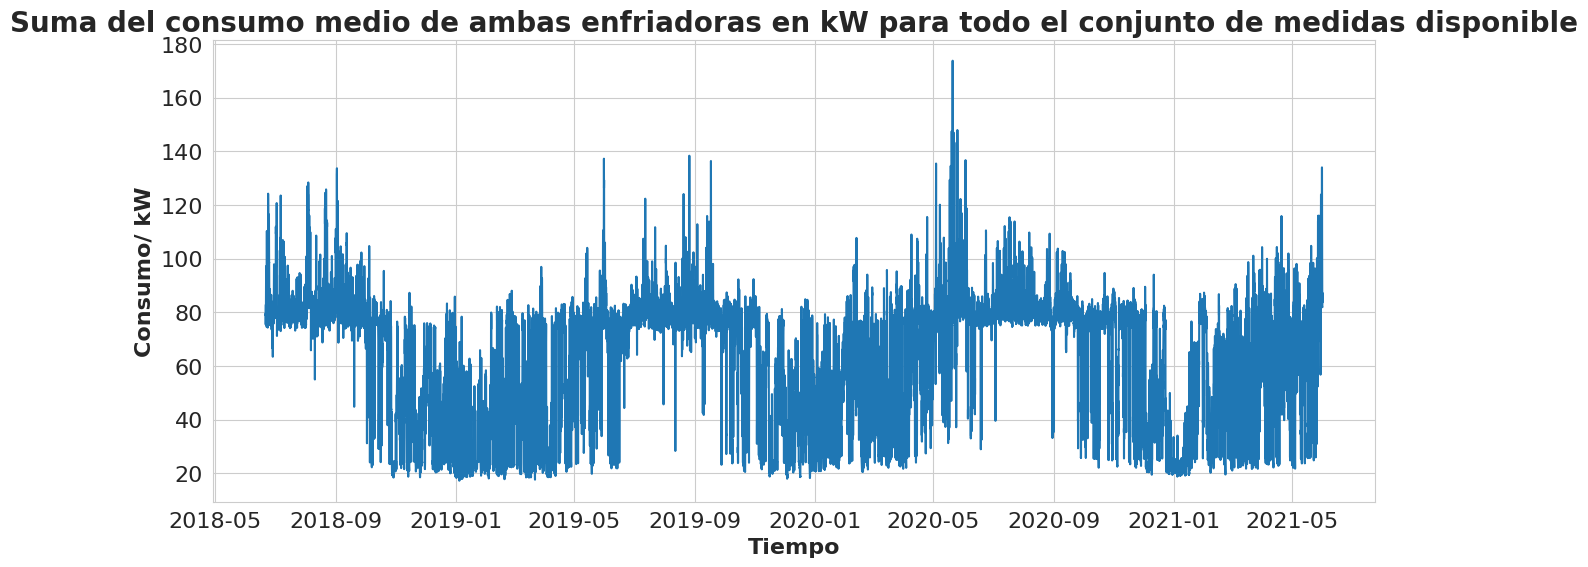

In [95]:
fig, ax = plt.subplots(figsize=(15, 6))
# sns.lineplot(
#     consumption_train["time"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")], consumption_train["total_average_power_consumption_kW_chillers"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")],
# )
sns.lineplot(data=consumption_train, x=consumption_train.index,y="total_average_power_consumption_kW_chillers")

ax.set_title(
#     "Sum of both chillers average consumption in kW during the whole available dataset",
    "Suma del consumo medio de ambas enfriadoras en kW para todo el conjunto de medidas disponible",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Tiempo", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Consumo/ kW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/chiller_consumption_wholeData_1hour.svg", format="svg",dpi =600)
plt.show()
plt.close()



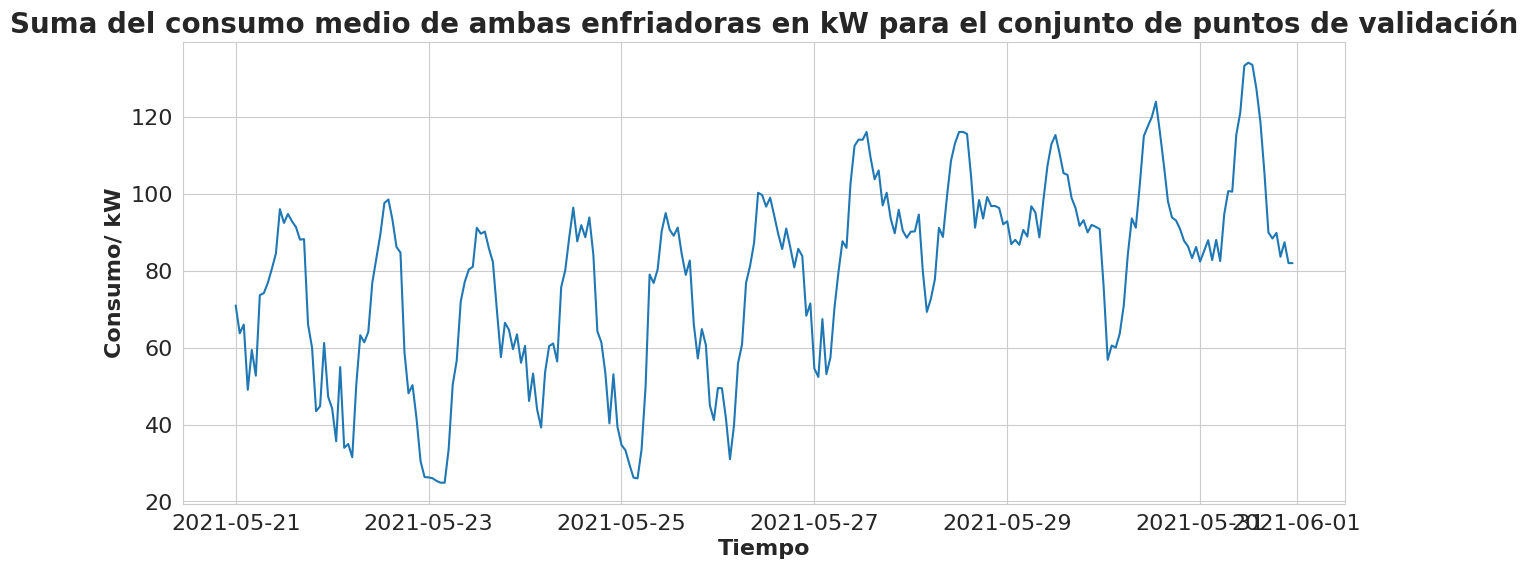

In [96]:
fig, ax = plt.subplots(figsize=(15, 6))
# sns.lineplot(
#     consumption_train["time"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")], consumption_train["total_average_power_consumption_kW_chillers"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")],
# )
# sns.lineplot(
#     consumption_train["time"], consumption_train["total_average_power_consumption_kW_chillers"],
# )
sns.lineplot(data=consumption_train[consumption_train.index >= pd.to_datetime("2021-05-21 00:00:00")], x=consumption_train[consumption_train.index >= pd.to_datetime("2021-05-21 00:00:00")].index,y="total_average_power_consumption_kW_chillers")

ax.set_title(
#     "Sum of both chillers average consumption in kW during the whole available dataset",
    "Suma del consumo medio de ambas enfriadoras en kW para el conjunto de puntos de validación",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Tiempo", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Consumo/ kW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/chiller_consumption_validationData_1hour.svg", format="svg",dpi =600)
plt.show()
plt.close()


Ya podemos notar que existen varias estacionalidades. Por lo menos diaria y anual (observese los altos consumos durante cada uno de los veranos. Esto implica que no podremos trabajar con metodos como Sarimax ya que estos contemplan una sola estacionalidad. Como notamos en la figura inferior, tambi'en parece haber una estacionaliad semanal

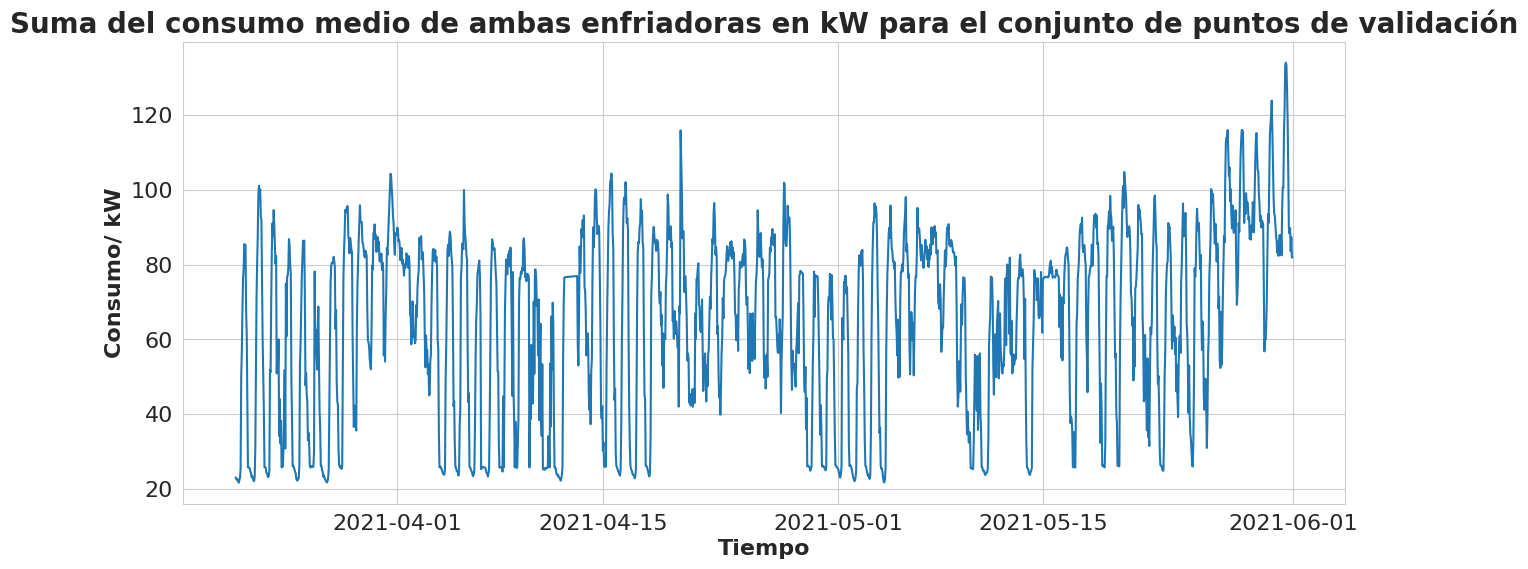

In [97]:
fig, ax = plt.subplots(figsize=(15, 6))
# sns.lineplot(
#     consumption_train["time"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")], consumption_train["total_average_power_consumption_kW_chillers"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")],
# )
# sns.lineplot(
#     consumption_train["time"], consumption_train["total_average_power_consumption_kW_chillers"],
# )
sns.lineplot(data=consumption_train[consumption_train.index >= pd.to_datetime("2021-03-21 00:00:00")], x=consumption_train[consumption_train.index >= pd.to_datetime("2021-03-21 00:00:00")].index,y="total_average_power_consumption_kW_chillers")

ax.set_title(
#     "Sum of both chillers average consumption in kW during the whole available dataset",
    "Suma del consumo medio de ambas enfriadoras en kW para el conjunto de puntos de validación",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Tiempo", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Consumo/ kW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/chiller_consumption_last3Months_1hour.svg", format="svg",dpi =600)
plt.show()
plt.close()


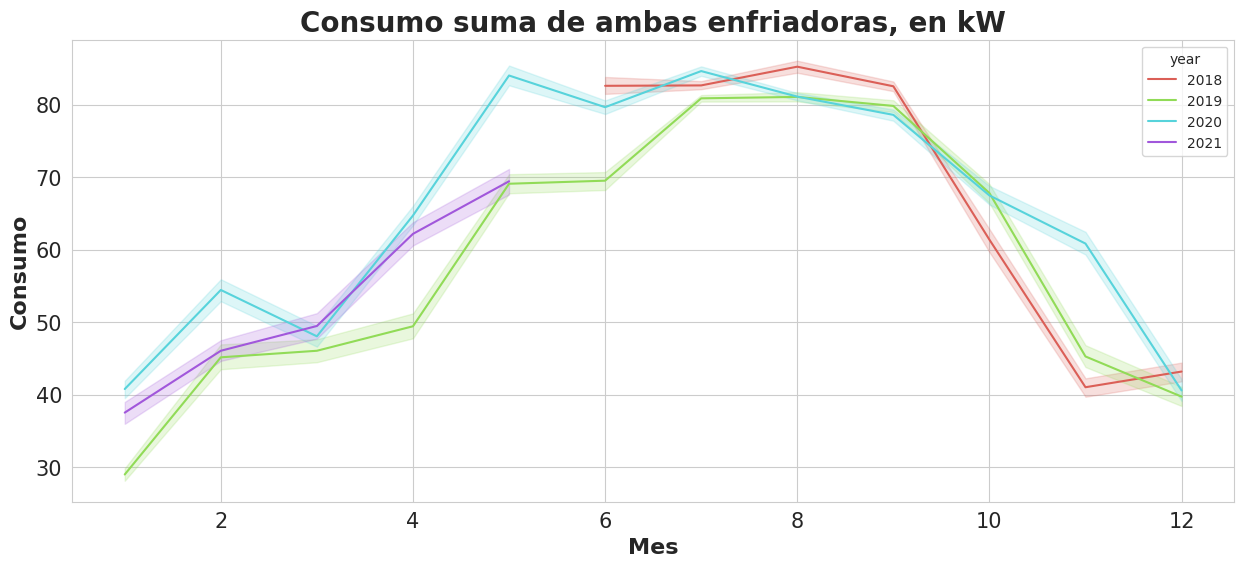

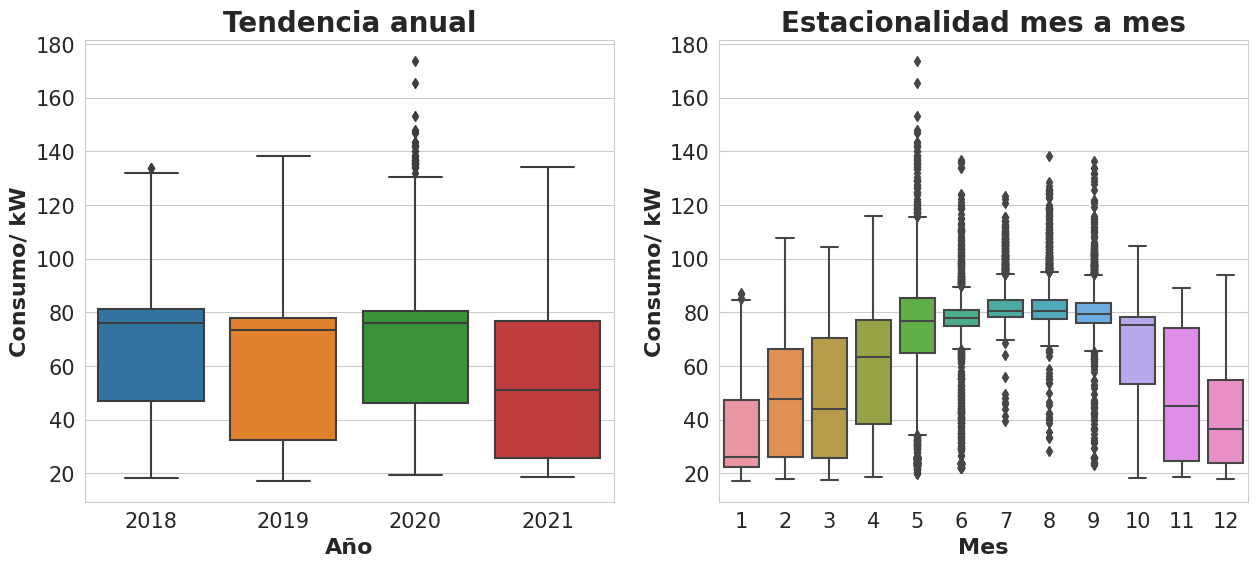

In [98]:
variable = "total_average_power_consumption_kW_chillers"
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("hls", 4)
sns.lineplot(data=consumption_train, x = consumption_train.month,y=variable,
    hue=consumption_train["year"],
    palette=palette,
)
ax.set_title(
    "Consumo suma de ambas enfriadoras, en kW",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Mes", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel("Consumo", fontsize=16, fontdict=dict(weight="bold"))
plt.savefig(
    visualization_path + "/chiller_consumption_Estacionalidad_1hour.svg", bbox_inches="tight"
)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot( data =consumption_train, x=consumption_train["year"], y=variable, ax=ax[0])
ax[0].set_title(
    "Tendencia anual", fontsize=20, loc="center", fontdict=dict(weight="bold")
)
ax[0].set_xlabel("Año", fontsize=16, fontdict=dict(weight="bold"))
ax[0].set_ylabel("Consumo/ kW", fontsize=16, fontdict=dict(weight="bold"))

sns.boxplot(data = consumption_train, x= consumption_train["month"], y=variable, ax=ax[1])
ax[1].set_title(
    "Estacionalidad mes a mes", fontsize=20, loc="center", fontdict=dict(weight="bold")
)
ax[1].set_xlabel("Mes", fontsize=16, fontdict=dict(weight="bold"))
ax[1].set_ylabel("Consumo/ kW", fontsize=16, fontdict=dict(weight="bold"))
plt.savefig(
    visualization_path + "/chiller_consumption_boxPlots_1hour.svg", bbox_inches="tight"
)
plt.show()


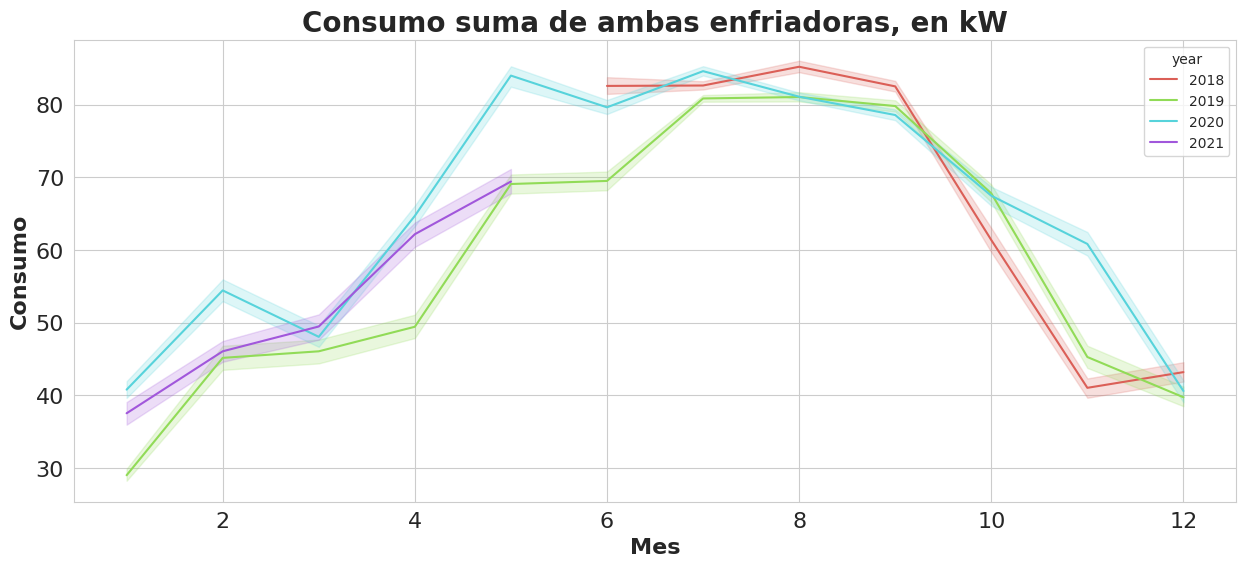

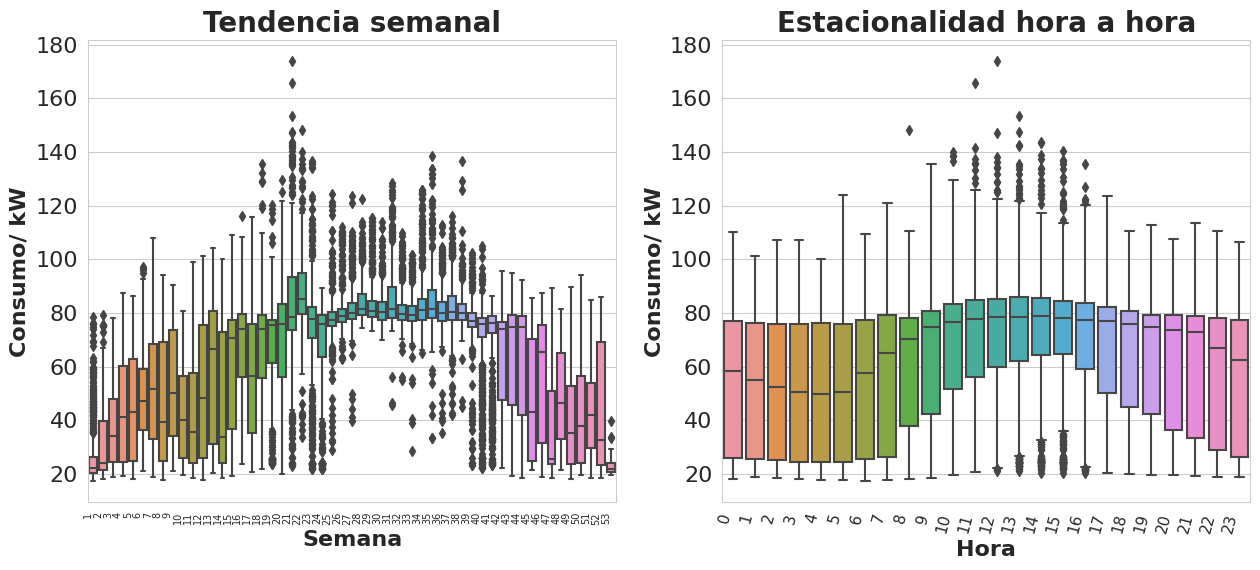

In [128]:
variable = "total_average_power_consumption_kW_chillers"
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("hls", 4)
sns.lineplot(data=consumption_train, x = consumption_train.month,y=variable,
    hue=consumption_train["year"],
    palette=palette,
)
ax.set_title(
    "Consumo suma de ambas enfriadoras, en kW",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Mes", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel("Consumo", fontsize=16, fontdict=dict(weight="bold"))
plt.savefig(
    visualization_path + "/chiller_consumption_Estacionalidad_1hour.svg", bbox_inches="tight"
)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot( data =consumption_train, x=consumption_train["week"], y=variable, ax=ax[0])
ax[0].set_title(
    "Tendencia semanal", fontsize=20, loc="center", fontdict=dict(weight="bold")
)
ax[0].set_xlabel("Semana", fontsize=16, fontdict=dict(weight="bold"))
ax[0].set_ylabel("Consumo/ kW", fontsize=16, fontdict=dict(weight="bold"))

sns.boxplot(data = consumption_train, x= consumption_train["hour"], y=variable, ax=ax[1])
ax[1].set_title(
    "Estacionalidad hora a hora", fontsize=20, loc="center", fontdict=dict(weight="bold")
)
ax[1].set_xlabel("Hora", fontsize=16, fontdict=dict(weight="bold"))
ax[1].set_ylabel("Consumo/ kW", fontsize=16, fontdict=dict(weight="bold"))
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=75, ha='right', fontsize=11)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right', fontsize=7)
plt.savefig(
    visualization_path + "/chiller_consumption_boxPlots_hourly_1hour.svg", bbox_inches="tight"
)
plt.show()


La semanal y la mensual es la misma estacionalidad, las semanas de los meses mas calidos son las que muestran mayor consumo

In [120]:
consumption_train

,total_average_power_consumption_kW_nodes,total_average_power_consumption_kW_chillers,Temperature_In_Degrees,Temperature_Out_Degrees,Temperature_Ambient_Degrees,Temperature_Evaporator_Degrees,max_pressure_Bars,n_working_compressors,year,month,week,day,hour
time,,,,,,,,,,,,,
2018-06-21 00:00:00,72.34,78.97,15.83,14.99,17.85,15.98,16.60,1.00,2018,6,25,21,0
2018-06-21 01:00:00,70.92,79.56,15.82,14.97,17.60,15.92,16.60,1.00,2018,6,25,21,1
2018-06-21 02:00:00,70.45,77.34,15.84,14.99,17.36,15.93,17.00,1.00,2018,6,25,21,2
2018-06-21 03:00:00,68.32,75.51,15.79,14.94,17.28,15.90,16.60,1.00,2018,6,25,21,3
2018-06-21 04:00:00,65.90,77.27,15.83,15.00,17.38,15.92,16.60,1.00,2018,6,25,21,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 19:00:00,65.07,89.81,17.53,14.96,15.77,16.25,17.00,1.00,2021,5,22,31,19
2021-05-31 20:00:00,64.94,83.62,17.48,15.03,15.32,16.17,17.00,1.00,2021,5,22,31,20
2021-05-31 21:00:00,66.82,87.39,17.52,14.97,15.28,16.22,17.00,1.00,2021,5,22,31,21


Similar comportamiento del consumo año a año entre las medidas disponibles. Notable cantidad de outlayers en la tendencia de 2020 (coronavirus?). Los meses de verano y mayo presentan una gran distancia entre el tercer y cuarto cuartil. También gran cantidad de puntos extremos. Esto es lógico. En verano es cuando la temperatura ambiente es mayor. De esto modo, no es posible aprovechar el Free Cooling y los compresores deben trabajar para enfriar el agua que viene caliente (18-25 grados) del CPD (Centro de Procesamiento de Datos) tras enfriar el aire de este último.

La funcion tsa.seasonal_decompose necesita recibir un ciclo si no lo puede inferir autom'aticamente del dataframe como es el caso. Usaremos la funcion de autorrelacion para estimar de forma grosera la estacionalidad y calcularemos cuantos puntos hay por ciclo estacional sabiendo que tenemos medidas cada media hora

Descomposicion aditiva ETS https://towardsdatascience.com/time-series-analysis-with-theory-plots-and-code-part-1-dd3ea417d8c4

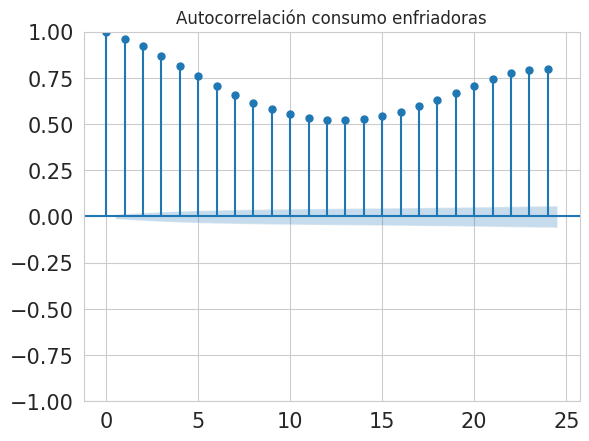

In [100]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_acf(x, lags=24)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

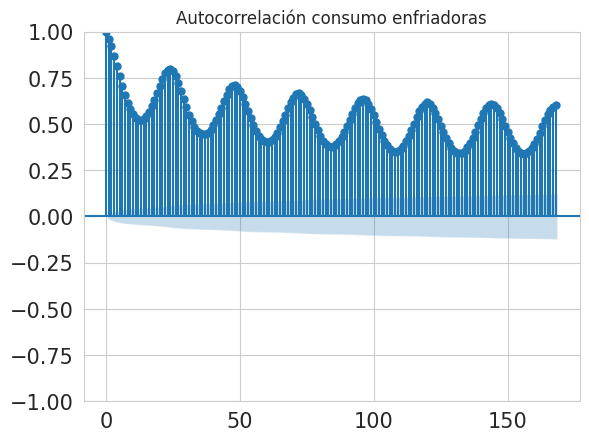

In [101]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_acf(x, lags=24*7)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

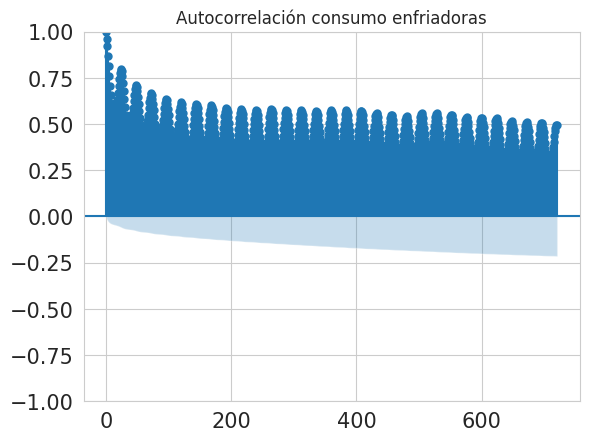

In [102]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_acf(x, lags=24*30)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

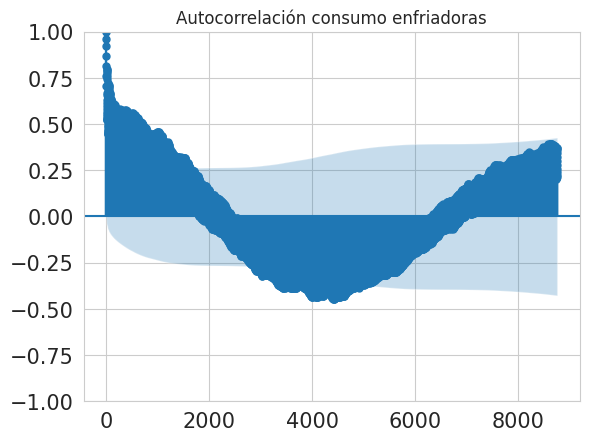

In [103]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_acf(x, lags=24*365)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

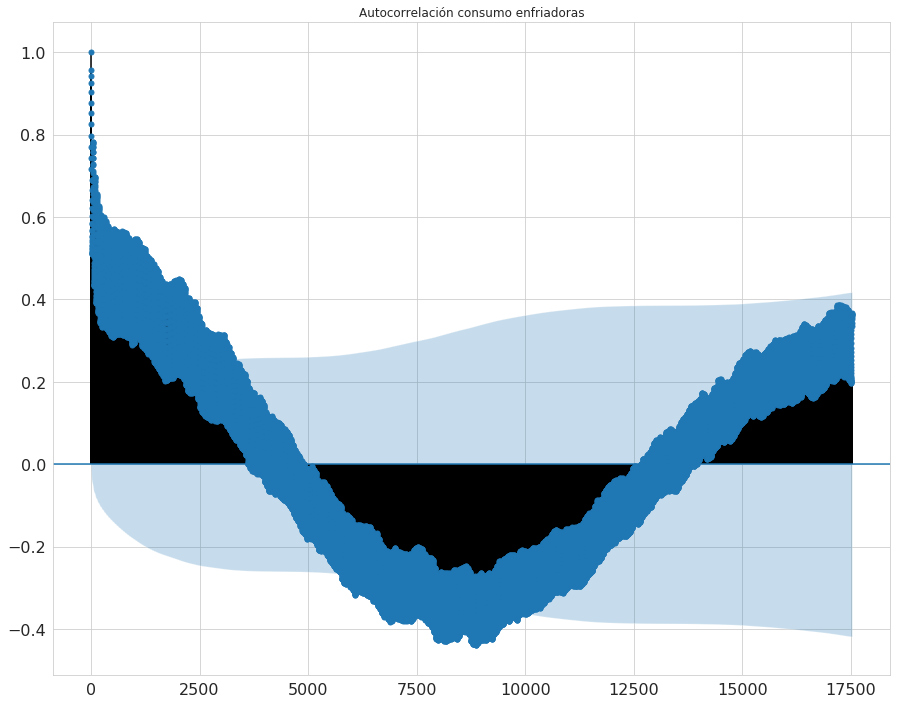

In [107]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_acf(x, lags=365*48)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

Fuerte autocorrelacion con un lag de 48*365, la serie temporal acabando en la misma fecha del año anterior. Notamos que entra en una region entre medias que parece esta en el rango del ruido blanco. Y que antes de entrar en esa regionan, en torno a 3000 puintos que son 60 dias

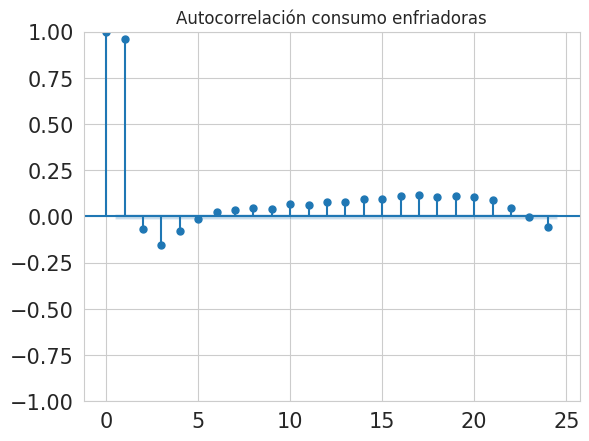

In [106]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_pacf(x, lags=24)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

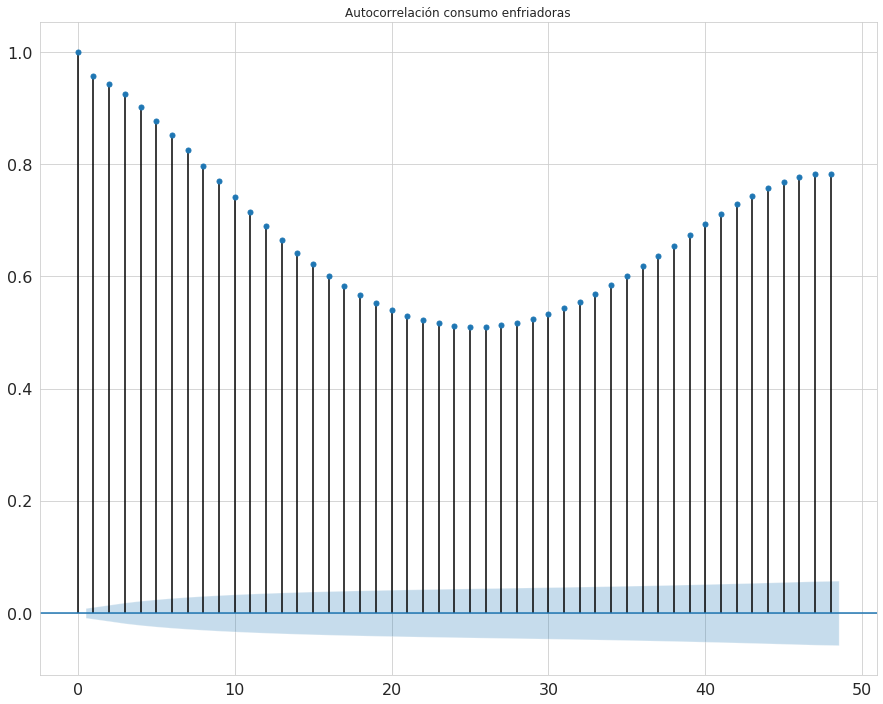

In [105]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_acf(x, lags=48)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

Como vemos gracias a la autocorrelacion, realmente las correlaciones intermedias son cofounding variables (entre 3 y 48). El valor previo que mas impacto tiene en el posterior es el inmediatamente anterior t-1 seguido de t-2 y t-3.

Clara autocorrelacion con lag 48, medida cada 30 minutos asi que periodo estacional diario

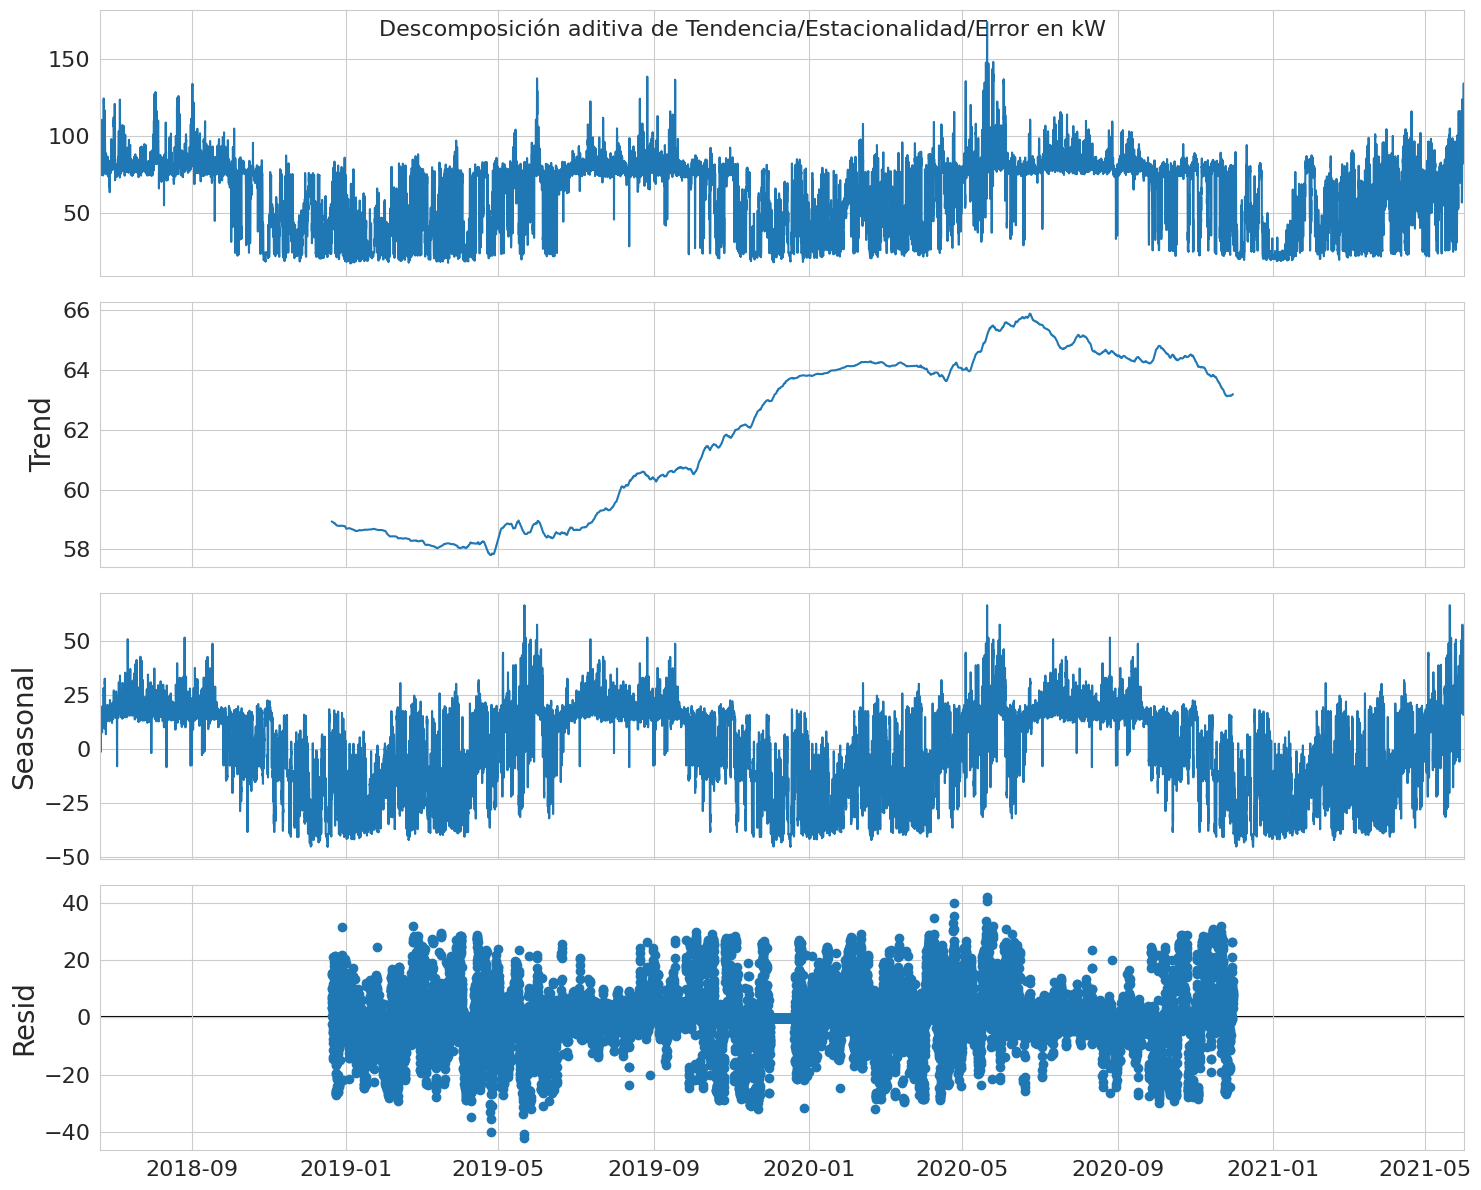

In [111]:
y = consumption_train[["total_average_power_consumption_kW_chillers"]].copy()

# y.time = pd.to_datetime(y.time)
# y.set_index("time", inplace=True, drop=True)
# y.index.freq=pd.infer_freq(y.index)
# y=y.asfreq("30min") #T stands for minutes for some reason https://stackoverflow.com/questions/54630027/how-to-set-frequency-with-pd-to-datetime?rq=1
# y.total_average_power_consumption_kW_chillers.fillna(y.total_average_power_consumption_kW_chillers.mean(), inplace=True)
rcParams["figure.figsize"] = 15, 12
rcParams["axes.labelsize"] = 20
rcParams["ytick.labelsize"] = 16
rcParams["xtick.labelsize"] = 16
decomposition = sm.tsa.seasonal_decompose(y, period=24*365,model="additive")
decomp = decomposition.plot()
decomp.suptitle(
    "Descomposición aditiva de Tendencia/Estacionalidad/Error en kW", fontsize=16
)
decomp.savefig(
    visualization_path + "/chiller_consumption_ETS_WholeData_1hour.svg", bbox_inches="tight"
)


La mayor cantidad de estacionalidad "Explicada se obtiene" con un ciclo de 48*365, un año

### Hoja de ruta:

Aplicar Test ADF

Mientras no sea estacionario: 
    
    Linealizar (transformaciones Box-Cox y diferenciación)

Si es estacionario:

    Calcular ACF y PACF para determinar valores p,q,d de métodos de la familia ARMA (autorregresivos).
    

In [113]:
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(y.total_average_power_consumption_kW_chillers)

In [114]:
test_result

(-7.698741389124198,
 1.3570911749846467e-11,
 49,
 25774,
 {'1%': -3.4306037421974103,
  '5%': -2.861652146517202,
  '10%': -2.56682969228625},
 165908.03078152137)

El p-value es menor que 0.05 (e incluso que 0.01). Podemos descartar la hipótesis nula y asumir que la serie es estacionaria, tal y como podría esperarse del caso de uso (el consumo de las enfriadoras depende de la necesidad de calentar agua, esta puede depender de forma indirecta de la demanda de los nodos del clúster a través de la temperatura del CPD, pero las dependencias directas que más peso tienen son la época del año para beneficiarse del Free Cooling o no (de ahí la estacionalidad tan marcada para lag de 48 puntos (24 horas), pero también de 48·365 (si la misma fecha del año anterior se hizo trabajar a los compresores es porque fue verano, luego ahora también))

In [115]:
test_pressure = adfuller(consumption_train.max_pressure_Bars)
test_pressure_summer = adfuller(pressure_train.max_pressure_Bars)

In [116]:
test_pressure

(-9.60435906741653,
 1.883482084135115e-16,
 49,
 25774,
 {'1%': -3.4306037421974103,
  '5%': -2.861652146517202,
  '10%': -2.56682969228625},
 89775.5471904181)

In [117]:
test_pressure_summer#

(-10.805483036246558,
 1.9682973585126537e-19,
 46,
 19753,
 {'1%': -3.4306810965422234,
  '5%': -2.8616863329342284,
  '10%': -2.566847889039956},
 9094.588065388445)

Ambas series problema son estacionarias

ARIMA no funciona bien para series estacionarias, para eso usa SARIMAX

Como hemos visto, nuestra serie tiene varias estacionalidades, Sarimax no funcionara correctamente, usamos BATS and TBATS. Tambien modelos de series temporales non aware de la estacionalidad y directamente modelos regresivos non aware de las caracteristicas de tendencia ciclo y estacionalidad (XgBoost etc)

# Bats and TBAS

Empezamos con la prediccion para 24 horas. Vamos a usar todo menos el ultimo dia. Del mismo modo, usaremos todo menos la ultima semana para la prediccion de una semana.

In [169]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.bats import BATS 
from sktime.forecasting.tbats import TBATS
from utils import smape, rmse
fg=np.arange(1,25)
y=consumption_train.total_average_power_consumption_kW_chillers
y_train, y_test = temporal_train_test_split(y,test_size=24)

#Metodo naive para comparar. Predecir las medidas del mismo dia el year anterior 
y_pred_baseline=y[-24*366:-24*365].values

In [148]:
#No necesitamos Box Cox en un principio ya que hemos pasado el test de dickey fueller
tbats_f = TBATS(use_box_cox=False,
                  use_trend=False,
                  use_damped_trend=False,
                  sp=[24, 24*365])
tbats_f.fit(y_train)#Trained for 41 minutes

In [170]:
#Training made in a different machine with more resources
with open(data_path+"/06_models/"+"tbats_1hour_lags_24_8760", "rb") as f:
    tbats_f = pickle.load(f)
y_pred_TBATS = tbats_f.predict(fg)

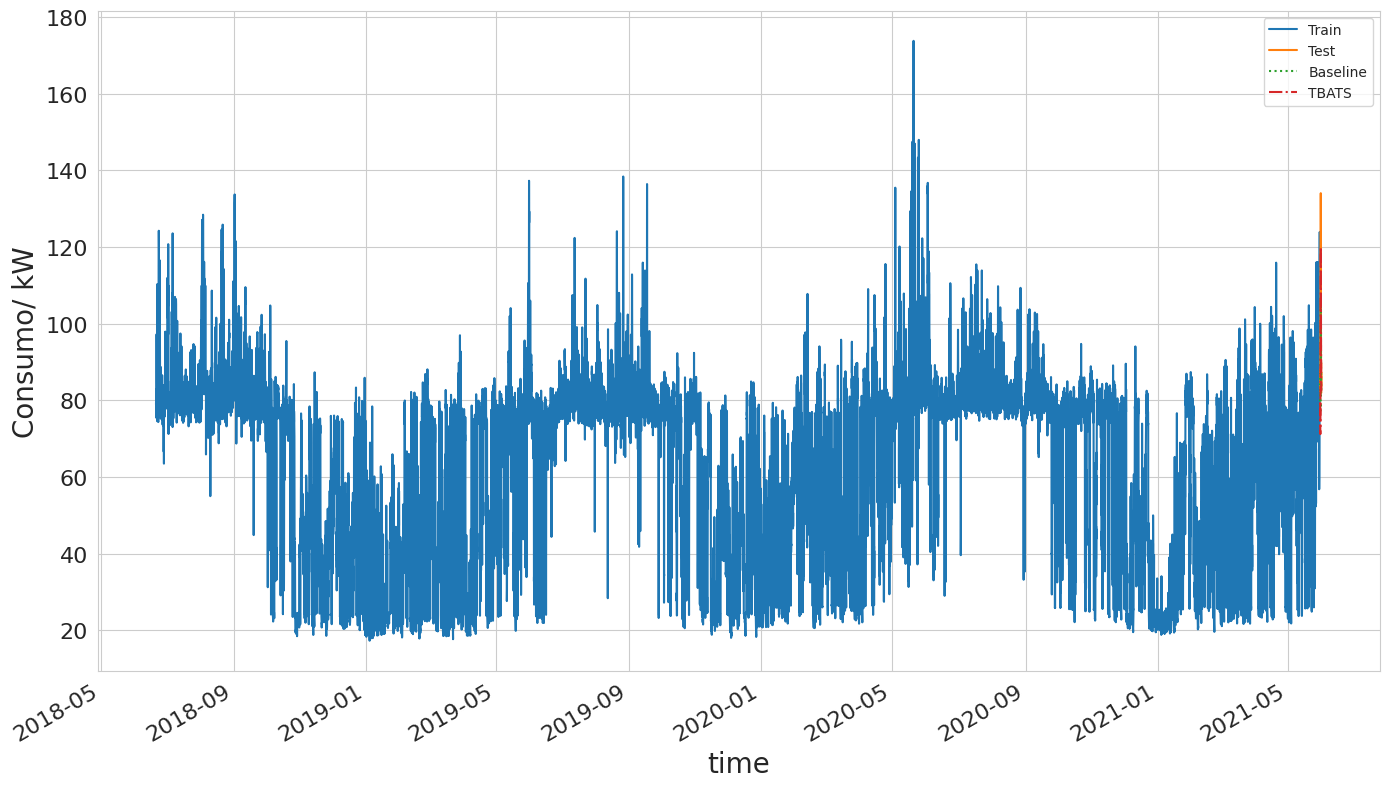

In [171]:
# y_pred_TBATS = pd.read_csv(data_path+"/07_model_output/"+"predictions_tbats_last24")
#Very difficult to appreciate like this, lets plot better
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_train, ls='-', label='Train')
ax.plot(y_test, ls='-', label='Test')
ax.plot(y_test.index, y_pred_baseline, ls=':', label='Baseline')
ax.plot(y_pred_TBATS, ls='-.', label='TBATS')
ax.set_xlabel('time')
ax.set_ylabel('Consumo/ kW')
ax.legend(loc='best')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

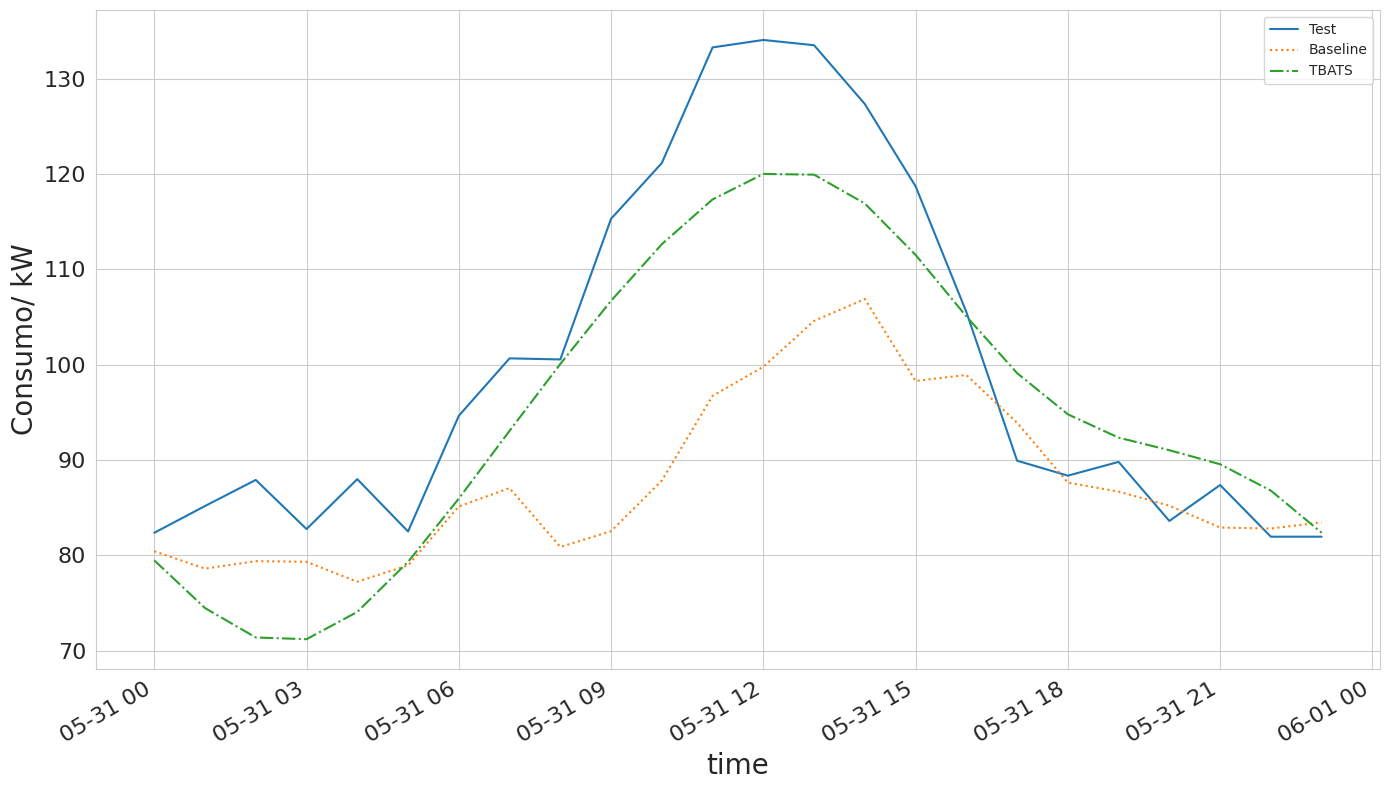

In [172]:
#It gets very difficult to being analyzed like this, lets plot just test against models
# y_pred_TBATS = pd.read_csv(data_path+"/07_model_output/"+"predictions_tbats_last24")
#Very difficult to appreciate like this, lets plot better
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_test, ls='-', label='Test')
ax.plot(y_test.index, y_pred_baseline, ls=':', label='Baseline')
ax.plot(y_pred_TBATS, ls='-.', label='TBATS')
ax.set_xlabel('time')
ax.set_ylabel('Consumo/ kW')
ax.legend(loc='best')
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(
    visualization_path + "/chiller_consumption_TBATS_last24Hours_hourly.svg", bbox_inches="tight", dpi=600
)
plt.show()

In [173]:
smape_tbats=smape(y_test, y_pred_TBATS)
rmse_tbats=rmse(y_test, y_pred_TBATS)
smape_baseline = smape(y_test, y_pred_baseline)
rmse_baseline= rmse(y_test, y_pred_baseline)

sMAPE from baseline: 12.5302804342077
sMAPE from TBATS: 8.051515412408031
RMSE from baseline: 17.53499051452898
RMSE from TBATS: 9.185831214199899


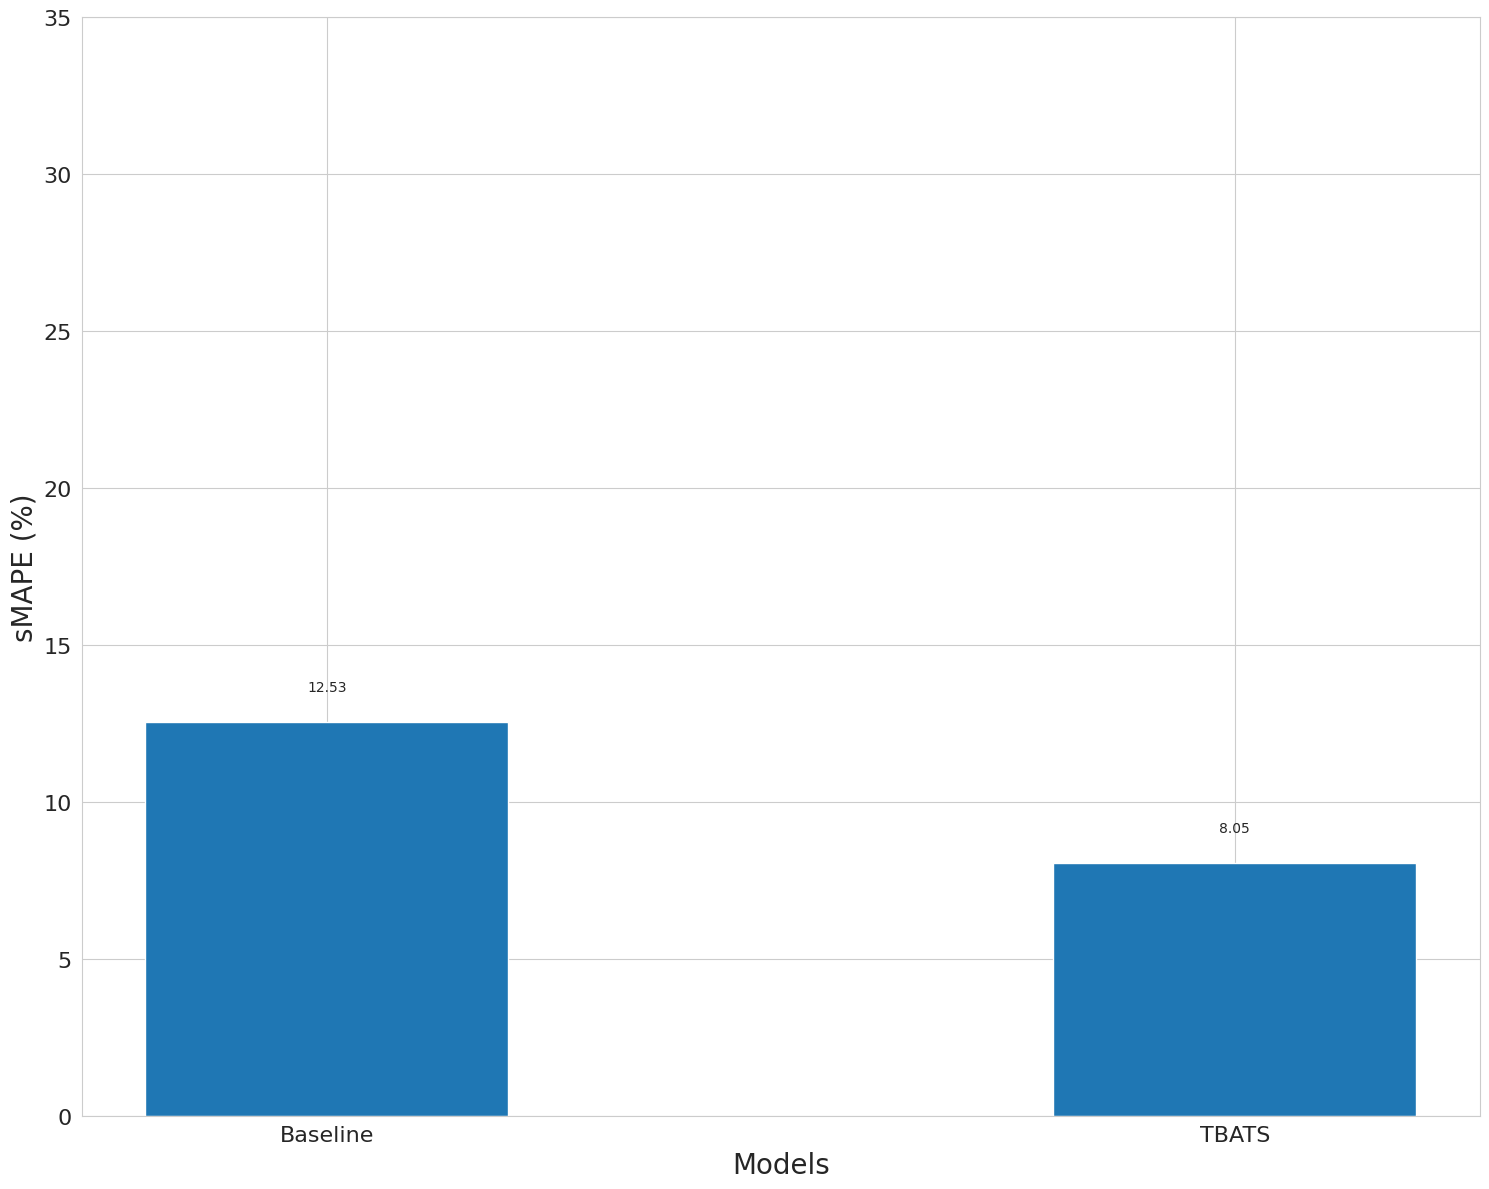

In [175]:
print(f'sMAPE from baseline: {smape_baseline}')
print(f'sMAPE from TBATS: {smape_tbats}')
print(f'RMSE from baseline: {rmse_baseline}')
print(f'RMSE from TBATS: {rmse_tbats}')
fig, ax = plt.subplots()
x = ['Baseline','TBATS']
y = [smape_baseline, smape_tbats]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('sMAPE (%)')
ax.set_ylim(0, 35)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
plt.tight_layout()

# 2- Estudio y forecasting (con y si variables exogenas) de las presiones que se alcanzan en verano de modo horario

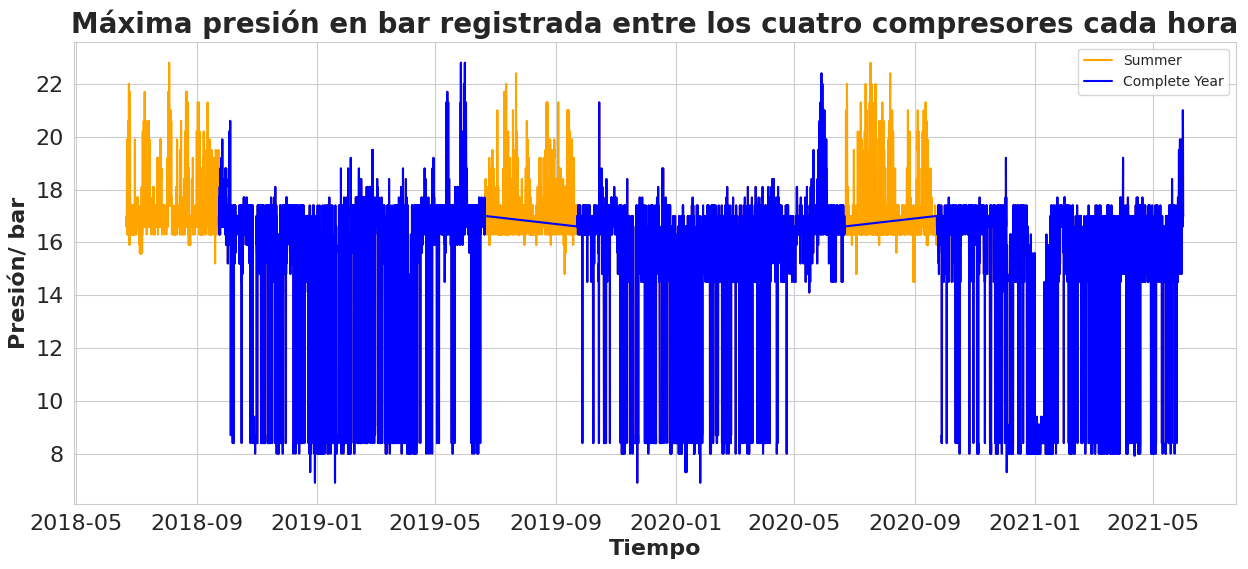

In [138]:
# check = pd.merge(pressure_train, consumption_train, on="time", how="left")
# dr1=(check.index >= pd.to_datetime("2019-06-21 00:00:00")) & (check.index < pd.to_datetime("2019-09-23 00:00:00"))
# dr2=(check.index >= pd.to_datetime("2020-06-21 00:00:00")) & (check.index < pd.to_datetime("2020-09-23 00:00:00"))
# check.loc[dr1, 'max_pressure_Bars_x'] = None
# check.loc[dr2, 'max_pressure_Bars_x'] = None
# fig, ax = plt.subplots(figsize=(15, 6))
# # sns.lineplot(
# #     consumption_train["time"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")], consumption_train["total_average_power_consumption_kW_chillers"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")],
# # )
# # sns.lineplot(
# #     consumption_train["time"], consumption_train["total_average_power_consumption_kW_chillers"],
# # )
# check=pd.merge(pressure_non_train, consumption_train, on="time", how="outer")
# sns.lineplot(data=pressure_train_withNan, x=pressure_train_withNan.index, y="max_pressure_Bars", color="Orange", label = "Summer")
# sns.lineplot(data=check, x=check.index, y="max_pressure_Bars_x", color="Blue", label = "Complete Year")

# ax.set_title(
# #     "Sum of both chillers average consumption in kW during the whole available dataset",
#     "Máxima presión en bar registrada entre los cuatro compresores cada hora",
#     fontsize=20,
#     loc="center",
#     fontdict=dict(weight="bold"),
# )
# ax.set_xlabel("Tiempo", fontsize=16, fontdict=dict(weight="bold"))
# ax.set_ylabel(
#     "Presión/ bar", fontsize=16, fontdict=dict(weight="bold")
# )
# plt.tick_params(axis="y", which="major", labelsize=16)
# plt.tick_params(axis="x", which="major", labelsize=16)
# plt.savefig(visualization_path+"/compressor_pressure_summers_1hour.svg", format="svg",dpi =600)
# plt.show()
# plt.close()


En este caso como cuando la temperatura ambiente es más alta que la temperatura de retorno pues una opción que se me ocurre para poder trabajar siempre con positivos es usar t_out - t_amb. Y si el valor es menor que cero entonces lo pondría a cero porque indica que no hay capacidad de enfriar el agua con el aire exterior. Fíjate que lo que cojo es t_out y no t_in para la fórmula (estrictamente lo que importa es la temperatura del agua caliente que vuelve a la enfriadora).

In [151]:
#adding new feature as suggested by Javier
pressure_train["Temperatura enfriamiento °C"] = pressure_train.Temperature_Out_Degrees - pressure_train.Temperature_Ambient_Degrees
pressure_train["Temperatura enfriamiento °C"]= pressure_train["Temperatura enfriamiento °C"].apply(lambda x: max(0, x))

Correlacion de Pearson significativa (mayor a 0.4) con el consumo total de las enfriadoras y con la temperatura ambiente.
Cuando queramos usar variable exogena, podemos predecirla con TBATS para ambas variables al tener ambas doble estacionalidad. Por ejemplo para Prophet


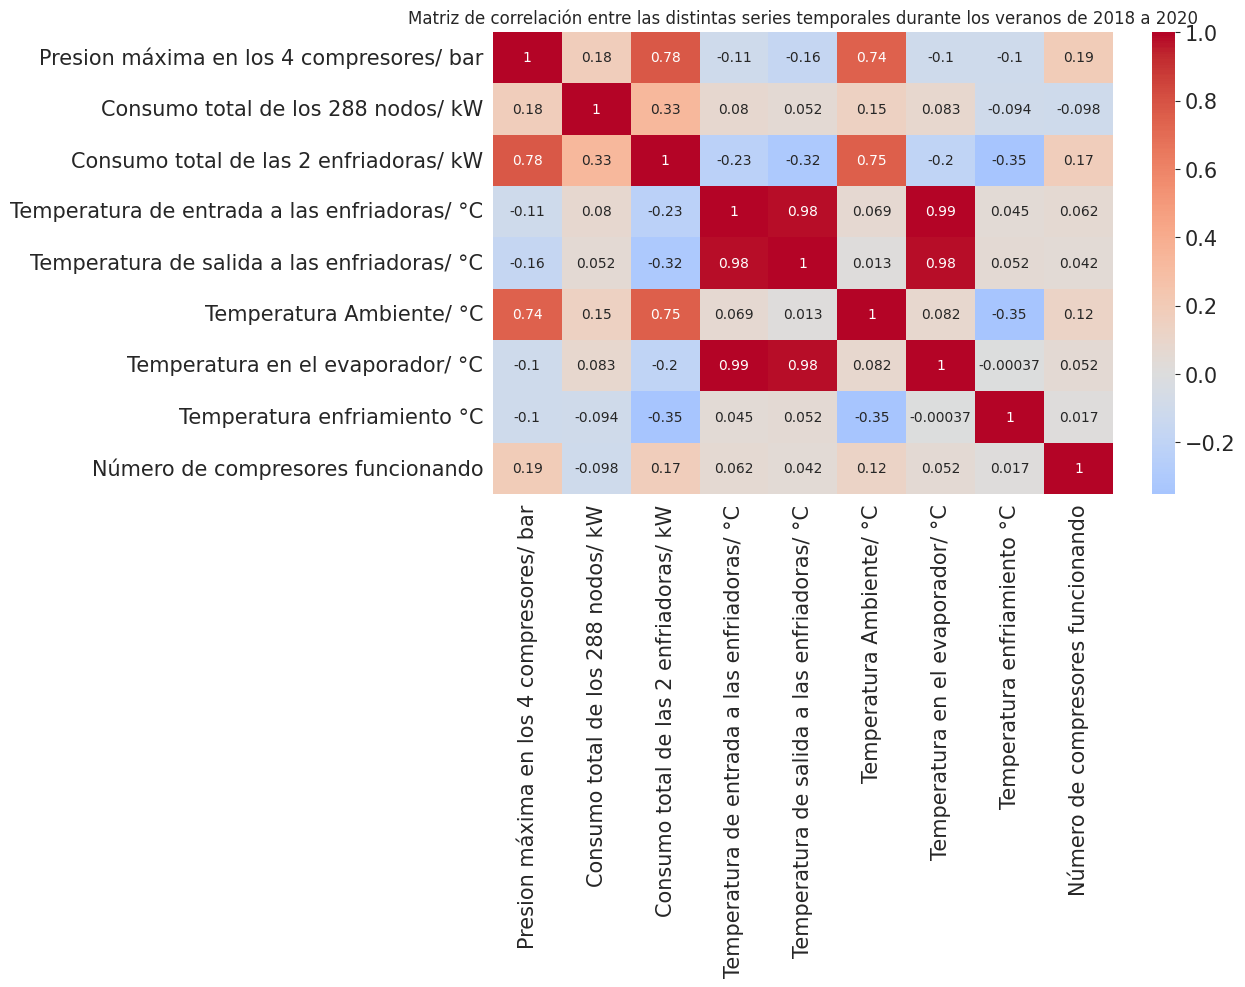

In [162]:
# adding new feature as suggested by Javier
pressure_train["Temperatura enfriamiento °C"] = (
    pressure_train.Temperature_Out_Degrees - pressure_train.Temperature_Ambient_Degrees
)
pressure_train["Temperatura enfriamiento °C"] = pressure_train[
    "Temperatura enfriamiento °C"
].apply(lambda x: max(0, x))
correlation_matrix = pressure_train[
    [
        "max_pressure_Bars",
        "total_average_power_consumption_kW_nodes",
        "total_average_power_consumption_kW_chillers",
        "Temperature_In_Degrees",
        "Temperature_Out_Degrees",
        "Temperature_Ambient_Degrees",
        "Temperature_Evaporator_Degrees",
        "Temperatura enfriamiento °C",
        "n_working_compressors",
    ]
].copy()
correlation_matrix.columns = [
    "Presion máxima en los 4 compresores/ bar",
    "Consumo total de los 288 nodos/ kW",
    "Consumo total de las 2 enfriadoras/ kW",
    "Temperatura de entrada a las enfriadoras/ °C",
    "Temperatura de salida a las enfriadoras/ °C",
    "Temperatura Ambiente/ °C",
    "Temperatura en el evaporador/ °C",
    "Temperatura enfriamiento °C",
    "Número de compresores funcionando",
]
correlation_matrix=correlation_matrix.corr()
# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title(
    "Matriz de correlación entre las distintas series temporales durante los veranos de 2018 a 2020"
)
plt.show()
